## Loading data

In [ ]:
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch
import scipy.io

In [ ]:
# Mounting colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Stanfard Car Dataset directory
base_path = '/content/drive/My Drive/301_Project/Datasets/Stanfard_Car_Datasets'
# Train and test images dataset path
cars_train_path = f'{base_path}/cars_train/cars_train'
cars_test_path = f'{base_path}/cars_test/cars_test'
# Annotations mat file path
annotations_path = f'{base_path}/cars_annos.mat'
annotations_train_path = f'{base_path}/cars_train_annos.mat'
annotations_test_path = f'{base_path}/cars_test_annos.mat'

Mounted at /content/drive


In [ ]:
train_mat = scipy.io.loadmat(annotations_train_path)
train_annotations = train_mat['annotations'][0]

test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

training_image_label_dictionary = {}

for annotation in train_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    training_image_label_dictionary[filename] = label

testing_image_label_dictionary = {}

for annotation in test_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    testing_image_label_dictionary[filename] = label

class_names = [i[0] for i in scipy.io.loadmat(annotations_path)['class_names'][0]]
print(f'There are {len(class_names)} classes in the dataset')

There are 196 classes in the dataset


## Data Analysis

### Analysis on the training set

In [ ]:
# visualize the class distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# showing the class names and their frequencies, vertical bar plot
plt.figure(figsize=(40, 10), dpi=500)
sns.countplot(x=[class_names[i] for i in training_image_label_dictionary.values()])
plt.xticks(rotation=90)
plt.title('Class Distribution for Training Set')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Analysis on the testing set

In [ ]:
# showing the class names and their frequencies, vertical bar plot
plt.figure(figsize=(40, 10), dpi=500)
sns.countplot(x=[class_names[i] for i in testing_image_label_dictionary.values()])
plt.xticks(rotation=90)
plt.title('Class Distribution for Testing Set')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Preprocessing dataset

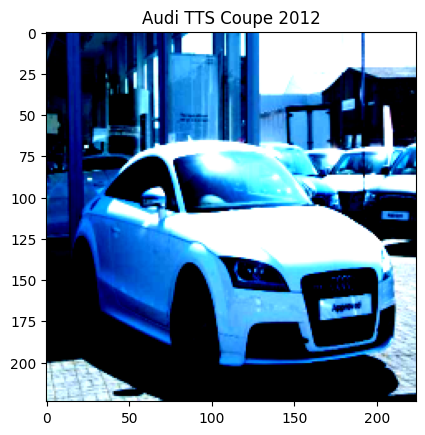

In [ ]:
class StanfordCarsDataset(Dataset):
    def __init__(self, directory, image_label_dict, transform=None):
        self.directory = directory
        self.image_label_dict = image_label_dict
        self.transform = transform
        self.images = list(image_label_dict.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.image_label_dict[self.images[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(), # Flip the image horizontally with a 50% chance
        # transforms.RandomRotation(20), # Rotate image by 20 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# initialize your datasets
train_dataset = StanfordCarsDataset(cars_train_path, training_image_label_dictionary, train_transforms)
test_dataset = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary, test_transforms)

# show an example image (after transformations) and its label
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.show()

## Model training and evaluation

In [ ]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### GoogleNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 166MB/s]
100%|██████████| 509/509 [05:39<00:00,  1.50it/s]


Epoch 1, Train Loss: 6.985, Train Accuracy: 0.081


100%|██████████| 503/503 [06:40<00:00,  1.26it/s]


Test Loss: 5.795, Test Accuracy: 0.172


100%|██████████| 509/509 [01:33<00:00,  5.46it/s]


Epoch 2, Train Loss: 5.463, Train Accuracy: 0.229


100%|██████████| 503/503 [01:24<00:00,  5.95it/s]


Test Loss: 6.485, Test Accuracy: 0.191


100%|██████████| 509/509 [01:34<00:00,  5.41it/s]


Epoch 3, Train Loss: 5.014, Train Accuracy: 0.287


100%|██████████| 503/503 [01:25<00:00,  5.90it/s]


Test Loss: 6.780, Test Accuracy: 0.201


100%|██████████| 509/509 [01:33<00:00,  5.45it/s]


Epoch 4, Train Loss: 4.787, Train Accuracy: 0.332


100%|██████████| 503/503 [01:25<00:00,  5.86it/s]


Test Loss: 6.951, Test Accuracy: 0.223


100%|██████████| 509/509 [01:34<00:00,  5.39it/s]


Epoch 5, Train Loss: 4.560, Train Accuracy: 0.367


100%|██████████| 503/503 [01:25<00:00,  5.90it/s]


Test Loss: 6.721, Test Accuracy: 0.252


100%|██████████| 509/509 [01:33<00:00,  5.45it/s]


Epoch 6, Train Loss: 4.299, Train Accuracy: 0.398


100%|██████████| 503/503 [01:24<00:00,  5.93it/s]


Test Loss: 7.707, Test Accuracy: 0.234


100%|██████████| 509/509 [01:34<00:00,  5.38it/s]


Epoch 7, Train Loss: 4.295, Train Accuracy: 0.416


100%|██████████| 503/503 [01:26<00:00,  5.84it/s]


Test Loss: 7.320, Test Accuracy: 0.258


100%|██████████| 509/509 [01:34<00:00,  5.36it/s]


Epoch 8, Train Loss: 4.130, Train Accuracy: 0.437


100%|██████████| 503/503 [01:24<00:00,  5.96it/s]


Test Loss: 7.468, Test Accuracy: 0.260


100%|██████████| 509/509 [01:34<00:00,  5.39it/s]


Epoch 9, Train Loss: 4.091, Train Accuracy: 0.448


100%|██████████| 503/503 [01:25<00:00,  5.89it/s]


Test Loss: 8.160, Test Accuracy: 0.248


100%|██████████| 509/509 [01:35<00:00,  5.34it/s]


Epoch 10, Train Loss: 4.220, Train Accuracy: 0.456


100%|██████████| 503/503 [01:26<00:00,  5.83it/s]


Test Loss: 8.102, Test Accuracy: 0.264


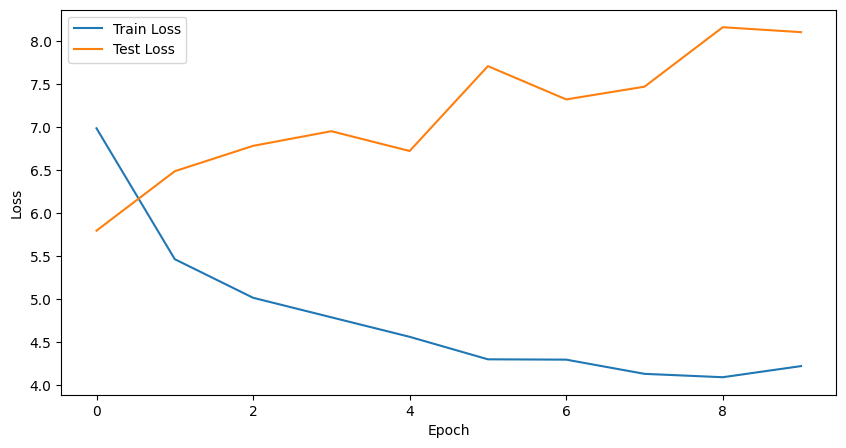

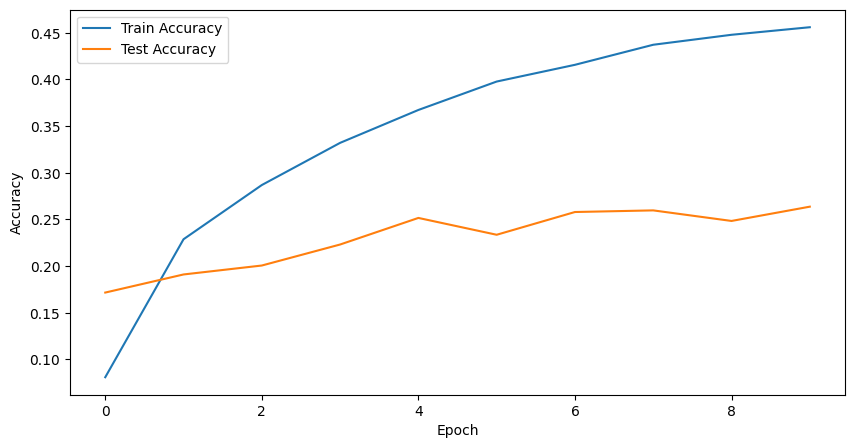

In [ ]:
# Save path
GoogleNet_path = '/content/drive/My Drive/301_Project/Model Development/googlenet_model.pth'
class GoogleNetModel(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNetModel, self).__init__()
        self.googlenet = torchvision.models.googlenet(pretrained=True)
        for param in self.googlenet.parameters():
            param.requires_grad = False
        self.googlenet.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.googlenet(x)

batch_size = 16
learning_rate = 0.01  # try reducing learning rate and use a lr scheduler
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = GoogleNetModel(num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}


# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("GoogleNet")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
torch.save(model.state_dict(), GoogleNet_path)

# remove the model and empty the cache
del model
torch.cuda.empty_cache()

### ResNet 50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]
100%|██████████| 509/509 [03:13<00:00,  2.63it/s]


Epoch 1, Train Loss: 14.609, Train Accuracy: 0.083


100%|██████████| 503/503 [02:57<00:00,  2.84it/s]


Test Loss: 13.089, Test Accuracy: 0.134


100%|██████████| 509/509 [03:13<00:00,  2.64it/s]


Epoch 2, Train Loss: 11.398, Train Accuracy: 0.214


100%|██████████| 503/503 [02:57<00:00,  2.84it/s]


Test Loss: 13.088, Test Accuracy: 0.197


100%|██████████| 509/509 [03:08<00:00,  2.70it/s]


Epoch 3, Train Loss: 10.725, Train Accuracy: 0.277


100%|██████████| 503/503 [02:57<00:00,  2.83it/s]


Test Loss: 14.988, Test Accuracy: 0.202


100%|██████████| 509/509 [03:12<00:00,  2.64it/s]


Epoch 4, Train Loss: 9.566, Train Accuracy: 0.349


100%|██████████| 503/503 [02:55<00:00,  2.86it/s]


Test Loss: 14.115, Test Accuracy: 0.220


100%|██████████| 509/509 [03:13<00:00,  2.63it/s]


Epoch 5, Train Loss: 8.870, Train Accuracy: 0.387


100%|██████████| 503/503 [02:55<00:00,  2.86it/s]


Test Loss: 14.188, Test Accuracy: 0.247


100%|██████████| 509/509 [03:15<00:00,  2.61it/s]


Epoch 6, Train Loss: 8.233, Train Accuracy: 0.439


100%|██████████| 503/503 [02:56<00:00,  2.85it/s]


Test Loss: 15.709, Test Accuracy: 0.257


100%|██████████| 509/509 [03:16<00:00,  2.60it/s]


Epoch 7, Train Loss: 8.025, Train Accuracy: 0.462


100%|██████████| 503/503 [02:58<00:00,  2.82it/s]


Test Loss: 15.545, Test Accuracy: 0.273


100%|██████████| 509/509 [03:17<00:00,  2.58it/s]


Epoch 8, Train Loss: 7.913, Train Accuracy: 0.486


100%|██████████| 503/503 [03:01<00:00,  2.78it/s]


Test Loss: 17.211, Test Accuracy: 0.268


100%|██████████| 509/509 [03:13<00:00,  2.63it/s]


Epoch 9, Train Loss: 7.416, Train Accuracy: 0.507


100%|██████████| 503/503 [02:58<00:00,  2.81it/s]


Test Loss: 18.065, Test Accuracy: 0.268


100%|██████████| 509/509 [03:14<00:00,  2.62it/s]


Epoch 10, Train Loss: 6.998, Train Accuracy: 0.532


100%|██████████| 503/503 [02:56<00:00,  2.85it/s]


Test Loss: 16.676, Test Accuracy: 0.284


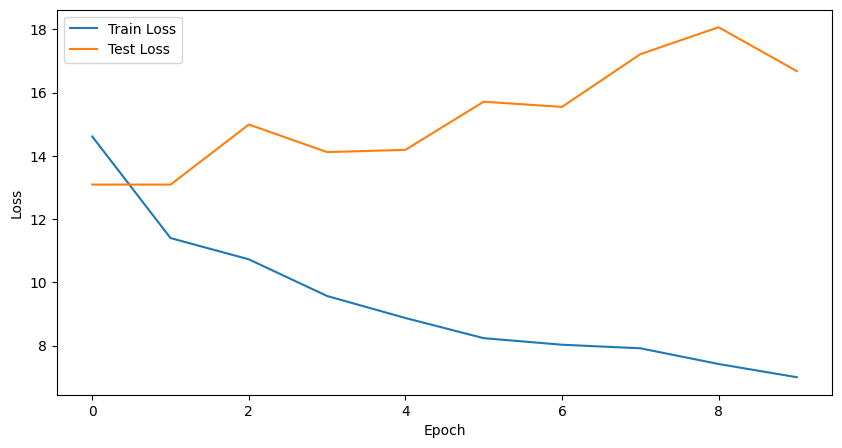

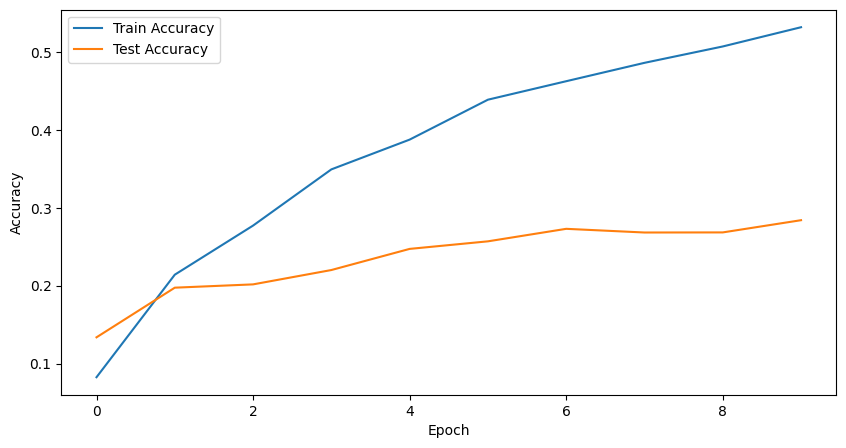

In [ ]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.resnet50(x)

batch_size = 16
learning_rate = 0.01
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ResNet50Model(num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())


# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')

plt.title("ResNet 50")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
ResNet_path = '/content/drive/My Drive/301_Project/Model Development/ResNet_path.pth'
torch.save(model.state_dict(), ResNet_path)

# remove the model and empty the cache
del model
torch.cuda.empty_cache()

### ViT

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 198MB/s]
100%|██████████| 509/509 [03:57<00:00,  2.14it/s]


Epoch 1, Train Loss: 5.258, Train Accuracy: 0.238


100%|██████████| 503/503 [03:24<00:00,  2.47it/s]


Test Loss: 4.457, Test Accuracy: 0.361


100%|██████████| 509/509 [03:57<00:00,  2.14it/s]


Epoch 2, Train Loss: 2.025, Train Accuracy: 0.613


100%|██████████| 503/503 [03:25<00:00,  2.45it/s]


Test Loss: 4.792, Test Accuracy: 0.380


100%|██████████| 509/509 [03:39<00:00,  2.31it/s]


Epoch 3, Train Loss: 1.305, Train Accuracy: 0.727


100%|██████████| 503/503 [03:26<00:00,  2.44it/s]


Test Loss: 4.579, Test Accuracy: 0.429


100%|██████████| 509/509 [03:41<00:00,  2.30it/s]


Epoch 4, Train Loss: 0.957, Train Accuracy: 0.801


100%|██████████| 503/503 [03:27<00:00,  2.43it/s]


Test Loss: 5.390, Test Accuracy: 0.410


100%|██████████| 509/509 [03:45<00:00,  2.26it/s]


Epoch 5, Train Loss: 0.853, Train Accuracy: 0.821


100%|██████████| 503/503 [02:50<00:00,  2.95it/s]


Test Loss: 5.851, Test Accuracy: 0.417


100%|██████████| 509/509 [03:41<00:00,  2.30it/s]


Epoch 6, Train Loss: 0.800, Train Accuracy: 0.839


100%|██████████| 503/503 [03:30<00:00,  2.39it/s]


Test Loss: 5.901, Test Accuracy: 0.443


100%|██████████| 509/509 [03:44<00:00,  2.27it/s]


Epoch 7, Train Loss: 0.622, Train Accuracy: 0.873


100%|██████████| 503/503 [03:37<00:00,  2.31it/s]


Test Loss: 6.404, Test Accuracy: 0.436


100%|██████████| 509/509 [03:44<00:00,  2.27it/s]


Epoch 8, Train Loss: 0.625, Train Accuracy: 0.877


100%|██████████| 503/503 [03:39<00:00,  2.29it/s]


Test Loss: 6.793, Test Accuracy: 0.440


100%|██████████| 509/509 [03:43<00:00,  2.28it/s]


Epoch 9, Train Loss: 0.589, Train Accuracy: 0.887


100%|██████████| 503/503 [02:58<00:00,  2.82it/s]


Test Loss: 6.956, Test Accuracy: 0.454


100%|██████████| 509/509 [03:31<00:00,  2.41it/s]


Epoch 10, Train Loss: 0.572, Train Accuracy: 0.894


100%|██████████| 503/503 [02:59<00:00,  2.80it/s]


Test Loss: 7.467, Test Accuracy: 0.450


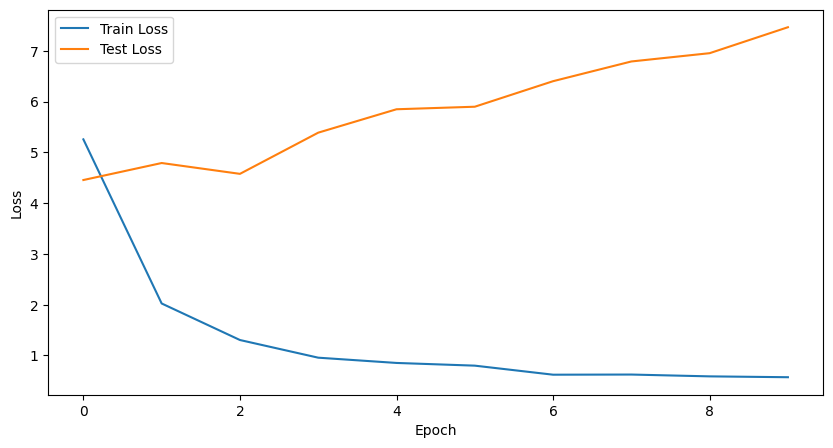

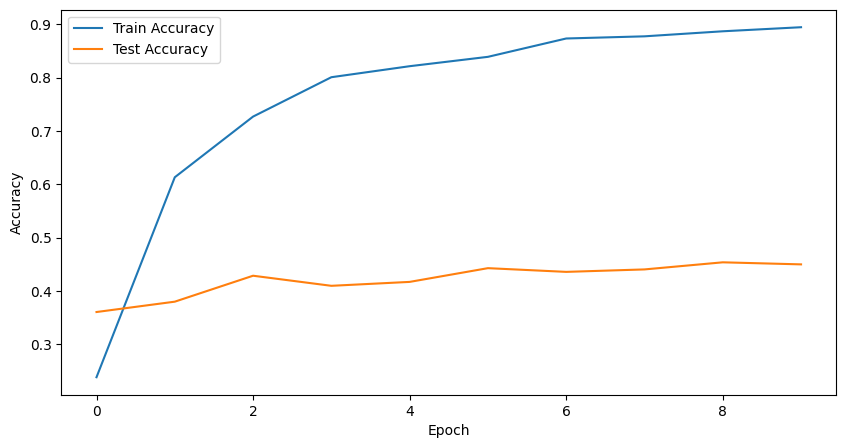

In [ ]:
# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(pretrained=True)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)


batch_size = 16
learning_rate = 0.01
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
Vit_path = '/content/drive/My Drive/301_Project/Model Development/Vit_path.pth'
torch.save(model.state_dict(), Vit_path)

# remove the model and empty the cache
del model
torch.cuda.empty_cache()